In [1]:
import datetime as dt
import os
import re
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import xarray as xr
from tqdm import tqdm

from distributed import Client, LocalCluster

# ***Copernicus Global Land Service Resampler***

## Purpose

This notebook shows how to resample Copernicus Global Land Service vegetation-related products (i.e. NDVI, FAPAR...), based on PROBA-V observations, from 333m resolution to 1km using R-based packages and functions.

It is intended for users who would like to continue, temporarily, their 1km time series, in near real-time, before switching to the new 333m baseline resolution.

## Initialization of the DASK Distributed env

After beening initializated processing flow can be followed through a browser at http://localhost:8787

In [ ]:
cluster = LocalCluster()
client = Client()

## Step 1: Data selection or download

Two approaches are preset to manage the data income; the user can define a specific file that is already present locally or, thanks to the downloader, select the specific product and date of interest. Both the approaches the definition of the output folder is needed.
In this folder will be written the downloaded product and the resampled file.

For more details on the products, please see the description and Product User Manuals documentation at https://land.copernicus.eu/global/products/

Define the output folder. If empty the same folder of the notebook will be used. 

In [2]:
folder = ''

### Option 1: Product is localy available

If the product is already available locally, the path must be defined as a string.

<span style="color:red">**NOTE!:Input file must be in netCDF (.nc) format and the output will be in the same format.
Tiff file can be read/outputed but the script version must be used**</span>

In [3]:
path = 'L:\ResampleTests\Data\c_gls_NDVI300_202011010000_GLOBE_OLCI_V2.0.1.nc'

### Option 2: Automatic procedure to download data from the Copernicus Global Land repository

To get access to the Copernicus Global Land repository user credential must be provided.  

Credential can be obtained here https://land.copernicus.vgt.vito.be/PDF/portal/Application.html#Home throught the Register form (on the upper right part of the page)

In [4]:
user = ''
psw = ''

Select the product and date of interest. Wait until the download is finish.
The selected date will be adjusted to the closest date available for the selected product. 

In [5]:
url = 'https://land.copernicus.vgt.vito.be/manifest/'

session = requests.Session()
session.auth = (user, psw)

manifest = session.get(url, allow_redirects=True)
products = pd.read_html(manifest.text)[0][2:-1]['Name']
products = products[products.str.contains('300_')].reset_index(drop=True)
print(products)
val = input('Please select the product from the list:')
url = f'{url}{products[int(val)]}'

manifest = session.get(url, allow_redirects=True)
product = pd.read_html(manifest.text)[0][-2:-1]['Name'].values[0]
purl = f'{url}{product}'
r = session.get(purl, stream=True)
rows = r.text.split('\n')
dates = pd.DataFrame()
for line in rows[:-1]:
    r = re.search(r"\d\d\d\d(\/)\d\d(\/)\d\d", line)
    dates = dates.append(pd.DataFrame([line], index=[pd.to_datetime(r[0], format="%Y/%m/%d")]))

val = input('Please insert the date in the format YYYY/MM/DD:')

dates = dates.sort_index()
i = dates.index.searchsorted(dt.datetime.strptime(val, "%Y/%m/%d"))
link = dates.iloc[i][0]
filename = os.path.basename(link)
if folder != '':
    path = sys.path.join(folder, filename)
else:
    path = filename

r = session.get(link, stream=True)

total_size = int(r.headers.get('content-length', 0))
block_size = 1024  # 1 Kibibyte
t = tqdm(total=total_size, unit='iB', unit_scale=True)

with open(path, 'wb') as f:
    for data in r.iter_content(block_size):
        t.update(len(data))
        f.write(data)
t.close()
if total_size != 0 and t.n != total_size:
    print("ERROR, something went wrong")

ImportError: lxml not found, please install it

## Step 2: Data ingestion

Dataset is readed and parameters are adjusted according to the product. No extra effort is needed to define the correct product parameters.

Note: As a global 300m data array has 120960 columns and 47040 rows, or close to 5.7bn cells, be aware that this could imply heavy use of computer resources. Xarray can easily manage this thanks to Dask and lazy approach. If you experience any problem with the memory define a chunk size as suggested in the module instructions.
More info is available here: http://xarray.pydata.org/en/stable/dask.html

In [6]:
ds = xr.open_dataset(path, mask_and_scale=False, chunks='auto')

Automatic selection of products parametes.

<span style="color:orange">**NOTE!: Be aware that for the nature of the upsampling not all the products or indexes can be processed.**</span>

In [7]:
if 'LAI' in ds.data_vars:
    product = 'LAI'
    da = ds.LAI
elif 'FCOVER' in ds.data_vars:
    product = 'FCOVER'
    da = ds.FCOVER
elif 'FAPAR' in ds.data_vars:
    product = 'FAPAR'
    da = ds.FAPAR
elif 'NDVI' in ds.data_vars:
    product = 'NDVI'
    da = ds.NDVI
elif 'DMP' in ds.data_vars:
    product = 'DMP'
    da = ds.DMP
elif 'GDMP' in ds.data_vars:
    product = 'GDMP'
    da = ds.GDMP

In [8]:
_, tail = os.path.split(path)
pos = [pos for pos, char in enumerate(tail) if char == '_'][2]
date = tail[pos + 1: pos + 9]
date_h = dt.datetime.strptime(date, '%Y%m%d').date()

# Step 3: Selection of the Area of Interest

To facilitate users, an Area of Interest (AOI), can be defined in the format [Long_min, Long_Max, Lat_min, Lat_Max]. Values must be expressed in decimal degree.

The extent will be adjusted according to the cell grid of the equivalent 1 Km product. If the AOI does not fit in the new grid, the leftish boundary will be truncated to the closest border of the 1km grid. 

If the AOI is not defined the entire dataset will be processed.

AOI definition 

In [9]:
AOI = [-18.58, 62.95, 51.57, 28.5]

AOI extent controll

In [10]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]
def bnd_box_adj(my_ext):
    lat_1k = np.round(np.arange(80., -60., -1. / 112), 8)
    lon_1k = np.round(np.arange(-180., 180., 1. / 112), 8)
    lat_300 = ds.lat.values
    lon_300 = ds.lon.values
    ext_1k = np.zeros(4)
    # UPL Long 1K
    ext_1k[0] = find_nearest(lon_1k, my_ext[0]) - 1. / 336
    # UPL Lat 1K
    ext_1k[1] = find_nearest(lat_1k, my_ext[1]) + 1. / 336
    # LOWR Long 1K
    ext_1k[2] = find_nearest(lon_1k, my_ext[2]) + 1. / 336
    # LOWR Lat 1K
    ext_1k[3] = find_nearest(lat_1k, my_ext[3]) - 1. / 336
    # UPL
    my_ext[0] = find_nearest(lon_300, ext_1k[0])
    my_ext[1] = find_nearest(lat_300, ext_1k[1])
    # LOWR
    my_ext[2] = find_nearest(lon_300, ext_1k[2])
    my_ext[3] = find_nearest(lat_300, ext_1k[3])
    return my_ext
if len(AOI):
    assert AOI[0] <= AOI[2], 'min Longitude is bigger than correspond Max, ' \
                                   'pls change position or check values.'
    assert AOI[1] >= AOI[3], 'min Latitude is bigger than correspond Max, ' \
                                   'pls change position or check values.'
    assert ds.lon[0] <= AOI[0] <= ds.lon[-1], 'min Longitudinal value out of original dataset Max ext.'
    assert ds.lat[-1] <= AOI[1] <= ds.lat[0], 'Max Latitudinal value out of original dataset Max ext.'
    assert ds.lon[0] <= AOI[2] <= ds.lon[-1], 'Max Longitudinal value out of original dataset Max ext.'
    assert ds.lat[-1] <= AOI[3] <= ds.lat[0], 'min Latitudinal value out of original dataset Max ext.'
    adj_ext = bnd_box_adj(AOI)
    try:
        da = da.sel(lon=slice(adj_ext[0], adj_ext[2]), lat=slice(adj_ext[1], adj_ext[3]))
    except Exception as ex:
        template = "An exception of type {0} occurred. Arguments:\n{1!r}"
        message = template.format(type(ex).__name__, ex.args)
        print(message)
        raise sys.exit(1)
else:
    da = da.shift(lat=1, lon=1)

## Step 4: Resampling using the aggregation approach

There are several approaches to resample data to a coarser resolution. 

As both products are provided in a regular latitude/longitude grid (plate carrée), with the ellipsoid WGS 1984 (Terrestrial radius=6378km), a Kernel can be used to achieve the resampling.
Products, usually named with a resolution of 1 km, have a resolution of the grid equal to 1/112°. Instead, products the nominally named os 333 m are defined by a resolution of 1/336°.
According to these values, a grid of 3x3 can be used to aggregate exactly a finner resolution product to the coarsen one.


Most of the products, some specific values are used to define qualitative information. These need to be masked out to avoid bias in the resampling.

Besides, it is advised to include a condition that at least 5 out of the 9 pixels had to have valid values (i.e. not NA). 


In [11]:
da_msk = da.where(da <= da.attrs['valid_range'][1])

create the coarsen dataset

In [12]:
coarsen = da_msk.coarsen(lat=3, lon=3, coord_func=np.mean, boundary='trim').mean(keep_attrs=True)
coarsen

<xarray.DataArray 'NDVI' (time: 1, lat: 3859, lon: 7858)>
dask.array<mean_agg-aggregate, shape=(1, 3859, 7858), dtype=float64, chunksize=(1, 2240, 4961), chunktype=numpy.ndarray>
Coordinates:
  * lat      (lat) float64 62.95 62.94 62.93 62.92 ... 28.53 28.52 28.51 28.5
  * lon      (lon) float64 -18.58 -18.57 -18.56 -18.55 ... 51.55 51.56 51.57
  * time     (time) datetime64[ns] 2020-11-01
Attributes:
    _FillValue:     255
    standard_name:  normalized_difference_vegetation_index
    long_name:      Normalized Difference Vegetation Index 333m
    grid_mapping:   crs
    scale_factor:   0.004
    add_offset:     -0.08
    units:          
    valid_range:    [  0 250]
    flag_values:    [254 255]
    flag_meanings:  Sea Missing
    missing_value:  255

mask the dataset according to the minumum required values

In [13]:
vo = xr.where(da <= da.attrs['valid_range'][1], 1, 0)
vo_cnt = vo.coarsen(lat=3, lon=3, coord_func=np.mean, boundary='trim').sum(keep_attrs=True)
da_r = coarsen.where(vo_cnt >= 5)

# Step 5: Check the outcome and data consolidation

Attributes and reference system are copied to the new dataset.

Note: as not all teh attributes are pertinet to the new product some of them are removed.

In [14]:
da_r.name = da.name
prmts = dict({da_r.name: {'dtype': 'f8', 'zlib': 'True', 'complevel': 4}})

dso = xr.Dataset({da_r.name: da_r, 'crs': ds.crs})
dso.attrs = ds.attrs
remove_list = ['processing_level', 'identifier', 'institution', 'processing_mode', 'archive_facility', 'parent_identifier', 'history']

for i in remove_list:
    dso.attrs.pop(i, '')
    dso.attrs['title'] = '10-daily Normalized Difference Vegetation Index 1Km resampled'


Data will be consolidated, on the disk, in netCDF format.

In [15]:
output_path = ''
da_r.to_netcdf(output_path, encoding=prmts)

C:\Users\Pier\Anaconda3\envs\trenove\lib\site-packages\dask\array\numpy_compat.py:40: RuntimeWarning: invalid value encountered in true_divide
  x = np.divide(x1, x2, out)


# Step 6: If needed data results can be plotted.

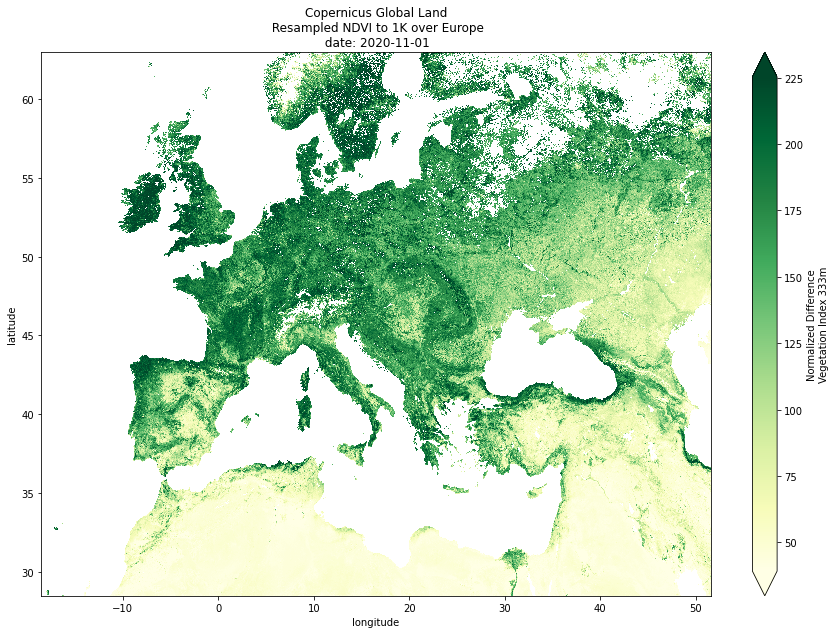

In [16]:
da_r.plot(robust=True, cmap='YlGn', figsize=(15, 10))
plt.title(f'Copernicus Global Land\n Resampled {da_r.name} to 1K over Europe\n date: {date_h}')
plt.ylabel('latitude')
plt.xlabel('longitude')
plt.draw()
plt.show()

Clean up of the Distributed setting

In [ ]:
cluster.close()
client.close()